In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

In [2]:
# makes inline plots to have better quality
%config InlineBackend.figure_format = 'svg'
# Set the default style
plt.style.use("seaborn")

# Neural Network for Rating Prediction

## Load preprocessed data

In [3]:
train = pd.read_pickle("data/df_train.pickle")
test = pd.read_pickle("data/df_test.pickle")

In [4]:
train

,review,rating
0,great speaker,3
1,great little,4
2,awesome,5
3,love,5
4,great device,5
...,...,...
6850,fun love,5
6851,lot fun,5
6852,buy gift husband problem set want return past ...,3
6853,set control light home thermostat love able se...,5


## Prepare data for neural network

In [5]:
# The maximum number of words to be used (most frequent)
MAX_NB_WORDS = 500
# Max number of words in each review
MAX_SEQUENCE_LENGTH = 50
# Embeddings dimension
EMBEDDING_DIM = 100

In [6]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True)
tokenizer.fit_on_texts(train['review'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 3646 unique tokens.


In [7]:
# Transform training data
X = tokenizer.texts_to_sequences(train['review'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)
y = pd.get_dummies(train['rating']).values

Shape of data tensor: (6765, 50)


In [8]:
y

array([[0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0]], dtype=uint8)

In [9]:
# Transform test data
X_test = tokenizer.texts_to_sequences(test['review'].values)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)
y_test = pd.get_dummies(test['rating']).values

Shape of data tensor: (6765, 50)


In [10]:
y_test

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0]], dtype=uint8)

In [11]:
# Make validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.15, random_state = 100)

## Build a model

In [15]:
def net():
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
    model.add(SpatialDropout1D(0.1))
    model.add(LSTM(100, dropout=0.1, recurrent_dropout=0.1))
    model.add(Dense(5, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

## Train the model and check validation scores

In [16]:
batch_size = 16
epochs = 10
es_callback = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

model = net()

history = model.fit(X_train, y_train, epochs=epochs, 
                    batch_size=batch_size, validation_split=0.1,
                    callbacks=[es_callback])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           50000     
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 5)                 505       
Total params: 130,905
Trainable params: 130,905
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
324/324 [==============================] - 19s 60ms/step - loss: 1.0052 - accuracy: 0.6433 - val_loss: 0.8688 - val_accuracy: 0.6609
Epoch 2/10
324/324 [==============================] - 19s 58ms/step - loss: 0.8451 - accuracy: 0.67

In [17]:
preds_val = np.argmax(model.predict(X_val), axis=1)
preds_train = np.argmax(model.predict(X_train), axis=1)

In [18]:
print("Training accuracy score: ", np.round(accuracy_score(np.argmax(y_train, axis=1), preds_train), 4))
print("Validation accuracy score: ", np.round(accuracy_score(np.argmax(y_val, axis=1), preds_val), 4))

Training accuracy score:  0.7746
Validation accuracy score:  0.6975


## Retrain the model on the whole training set and predict on test set

In [19]:
batch_size = 16
epochs = 10
es_callback = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

model = net()

history = model.fit(X, y, epochs=epochs, 
                    batch_size=batch_size, validation_split=0.1,
                    callbacks=[es_callback])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           50000     
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 130,905
Trainable params: 130,905
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
381/381 [==============================] - 22s 57ms/step - loss: 0.9863 - accuracy: 0.6490 - val_loss: 0.8424 - val_accuracy: 0.6809
Epoch 2/10
381/381 [==============================] - 22s 57ms/step - loss: 0.8297 - accuracy: 0.

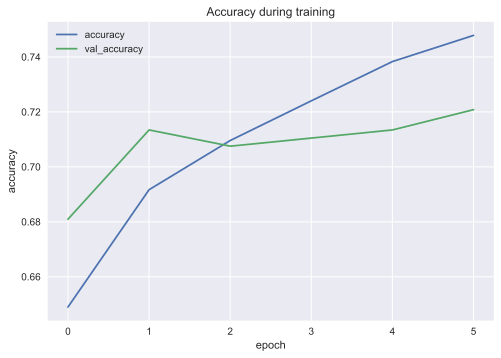

In [20]:
# Summarize history for accuracy
df_result = pd.DataFrame(history.history)
df_result[['accuracy', 'val_accuracy']].plot()
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.savefig('img/nn_accuracy.png', dpi=100)
plt.title("Accuracy during training")
plt.show()

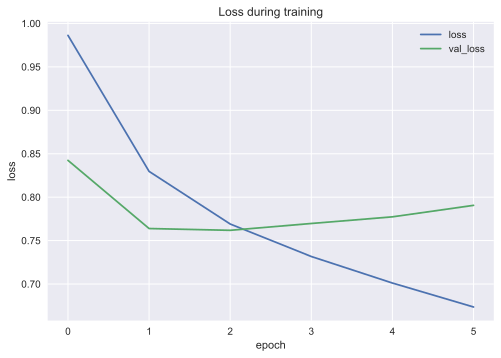

In [21]:
# Summarize history for accuracy
df_result = pd.DataFrame(history.history)
df_result[['loss', 'val_loss']].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.savefig('img/nn_loss.png', dpi=100)
plt.title("Loss during training")
plt.show()

In [22]:
preds_test = np.argmax(model.predict(X_test), axis=1)

In [23]:
print("Accuracy score on the test set: ", np.round(accuracy_score(np.argmax(y_test, axis=1), preds_test), 4))

Accuracy score on the test set:  0.7091


In [24]:
print("F1 score on the test set: ", np.round(f1_score(np.argmax(y_test, axis=1), preds_test, average='weighted'), 4))

F1 score on the test set:  0.7037
